## 1. Data Collection

### 1.1 Import Library

In [1]:
import os
import sys
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Warnings and logging
import warnings
import logging
warnings.filterwarnings("ignore")

# Append the correct src path for custom module imports
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../data'))
sys.path.append(os.path.abspath('../notebook/models'))
#from custom_logging import info_logger, error_logger

In [3]:
# from data_processing import load_data, clean_data, handle_missing_values
# from sale_analysis import (
#     plot_sales_distribution,
#     compare_sales_holidays,
#     seasonal_behavior,
#     correlation_analysis,
#     promo_effect,
#     effective_promo_deployment,
#     customer_behavior_trends,
#     weekday_openings,
#     assortment_type_impact,
#     competitor_distance_impact,
#     new_competitor_effects, 
#     plot_promo_distribution,
#     plot_sales_during_holidays,
#     plot_sales_customers_corr, 
#     plot_store_corr
# )

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


### 1.2 Load the Data

In [5]:
# Load datasets
train_data = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')
test_data = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
store_data = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')

## 2. Data Preprocesssing

#### 2.1 Summary of Dataset

In [6]:
train_data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [7]:
train_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
test_data.dtypes

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [9]:
store_data.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [10]:
store_data.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


### 2.2 Data Cleaning

In [11]:
#check missing values in training dataset
train_data.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [12]:
# Check missing values in testing load_data
test_data.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [13]:
# Check missing values on store data
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### 2.3 Merge the dataset

In [14]:
# Merging the training and store data on Store ID
train_merged = pd.merge(train_data, store_data, on='Store', how='left')

# Merging the training and store data on Store ID
test_merged = pd.merge(test_data, store_data, on='Store', how='left')

# Final combined data
df = pd.concat([train_merged, test_merged], axis=0)

In [15]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Id
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,NaN
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",NaN
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NaN
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,NaN
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,NaN


In [16]:
df.shape

(1058297, 19)

In [17]:
# check missing values
df.isnull().sum()

Store                              0
DayOfWeek                          0
Date                               0
Sales                          41088
Customers                      41088
Open                              11
Promo                              0
StateHoliday                       0
SchoolHoliday                      0
StoreType                          0
Assortment                         0
CompetitionDistance             2738
CompetitionOpenSinceMonth     338564
CompetitionOpenSinceYear      338564
Promo2                             0
Promo2SinceWeek               525263
Promo2SinceYear               525263
PromoInterval                 525263
Id                           1017209
dtype: int64

### 2.4 Handling Missing Values

In [18]:
# Fill missing Sales and Customers with 0 (assuming the store was closed when Sales/Customers are missing)
df['Sales'].fillna(0, inplace=True)
df['Customers'].fillna(0, inplace=True)

# Fill missing 'Open' values with 0 (assuming store was closed when this is missing)
df['Open'].fillna(0, inplace=True)

# Fill missing CompetitionDistance with a large number indicating no nearby competition
df['CompetitionDistance'].fillna(df['CompetitionDistance'].max() + 1, inplace=True)

# Fill missing CompetitionOpenSinceMonth and Year with default values (e.g., month=1, year=2000)
df['CompetitionOpenSinceMonth'].fillna(1, inplace=True)  # Assume January as default month
df['CompetitionOpenSinceYear'].fillna(2000, inplace=True)  # Assume year 2000 as default year

# Fill missing Promo2-related columns with zeros or a default value indicating no promotion
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna('No Promo', inplace=True)

# Optionally drop the 'Id' column if you are not making predictions (for training purposes)
if 'Id' in df.columns:
    df.drop(columns=['Id'], inplace=True)

# Verify if there are still missing values
print(df.isnull().sum())


Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


### 2.5 Feature Engineering

In [19]:
# Convert datetime column to pandas datetime
df['Date'] = pd.to_datetime(df['Date'])

In [20]:
# Extract date-based features
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['IsBeginningOfMonth'] = df['Day'].apply(lambda x: 1 if x <= 7 else 0)
df['IsMidMonth'] = df['Day'].apply(lambda x: 1 if 8 <= x <= 21 else 0)
df['IsEndOfMonth'] = df['Day'].apply(lambda x: 1 if x > 21 else 0)

In [21]:
# Additional features: Days to nearest holidays
# add logic here to compute 'days to next holiday' and 'days after holiday' based on a holiday dataset.

# Label encode categorical features
categorical_features = ['StoreType', 'Assortment', 'PromoInterval']
label_encoder = LabelEncoder()
for col in categorical_features:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Handle missing values, e.g., fill missing competition distance with the median
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

In [22]:
# Scale the data
scaler = StandardScaler()
scaled_columns = ['CompetitionDistance', 'Day', 'WeekOfYear', 'Month', 'Year']
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])


In [23]:
# Define the target (sales) and features
X = df.drop(columns=['Sales', 'Date'])
y = df['Sales']

In [24]:
# Check for non-numeric columns in the feature set
non_numeric_columns = X.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Apply One-Hot Encoding to categorical columns (if any)
X_encoded = pd.get_dummies(X, columns=non_numeric_columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


Non-numeric columns: Index(['StateHoliday'], dtype='object')


## 2.7 Training the Pipeline model

## XGBoost Model

In [25]:
from xgboost import XGBRegressor

# Define XGBoost model within a pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(n_estimators=100, random_state=42))
])

# Fit the model
xgb_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_train_xgb = xgb_pipeline.predict(X_train)
y_pred_test_xgb = xgb_pipeline.predict(X_test)


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the evaluation function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2


In [27]:
mse_train_xgb, mae_train_xgb, r2_train_xgb = evaluate_model(y_train, y_pred_train_xgb)
print(f"XGBoost Training Set - MSE: {mse_train_xgb}, MAE: {mae_train_xgb}, R2: {r2_train_xgb}")

mse_test_xgb, mae_test_xgb, r2_test_xgb = evaluate_model(y_test, y_pred_test_xgb)
print(f"XGBoost Test Set - MSE: {mse_test_xgb}, MAE: {mae_test_xgb}, R2: {r2_test_xgb}")


XGBoost Training Set - MSE: 245305.298933152, MAE: 338.51791596411414, R2: 0.9841587643466317
XGBoost Test Set - MSE: 257612.70313602756, MAE: 343.3028029616888, R2: 0.9833919999174038


## Random forest model

In [28]:
# Check for non-numeric columns in the feature set
non_numeric_columns = X.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Apply One-Hot Encoding to categorical columns (if any)
X_encoded = pd.get_dummies(X, columns=non_numeric_columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define RandomForest model within a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)


Non-numeric columns: Index(['StateHoliday'], dtype='object')


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

### 2.3 Choose a loss function

In [31]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Predict and evaluate
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Evaluate on training set
mse_train, mae_train, r2_train = evaluate_model(y_train, y_pred_train)
print(f"Training Set - MSE: {mse_train}, MAE: {mae_train}, R2: {r2_train}")

# Evaluate on test set
mse_test, mae_test, r2_test = evaluate_model(y_test, y_pred_test)
print(f"Test Set - MSE: {mse_test}, MAE: {mae_test}, R2: {r2_test}")


Training Set - MSE: 25598.328445346586, MAE: 94.3813865564581, R2: 0.9983469205312782
Test Set - MSE: 182804.90191507697, MAE: 253.74596702258341, R2: 0.9882147743913797


In [33]:
# Extract the RandomForest model from the pipeline
rf_model = pipeline.named_steps['model']

# Get feature importances from the RandomForest model
importances = rf_model.feature_importances_

# Retrieve feature names after encoding
feature_names = X_encoded.columns

# Check the length of feature_names and feature importances
print(f"Length of feature names: {len(feature_names)}")
print(f"Length of feature importances: {len(importances)}")

# Display the feature importances with corresponding feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

Length of feature names: 28
Length of feature importances: 28
                      Feature  Importance
2                   Customers    0.869655
6                   StoreType    0.029907
8         CompetitionDistance    0.026530
4                       Promo    0.016566
0                       Store    0.015500
12            Promo2SinceWeek    0.006256
10   CompetitionOpenSinceYear    0.005941
7                  Assortment    0.005099
9   CompetitionOpenSinceMonth    0.005035
1                   DayOfWeek    0.004636
16                 WeekOfYear    0.002838
13            Promo2SinceYear    0.002784
15                        Day    0.002612
14              PromoInterval    0.002342
18                       Year    0.001325
17                      Month    0.001253
19                  IsWeekend    0.000354
5               SchoolHoliday    0.000345
11                     Promo2    0.000277
21                 IsMidMonth    0.000236
22               IsEndOfMonth    0.000123
24            

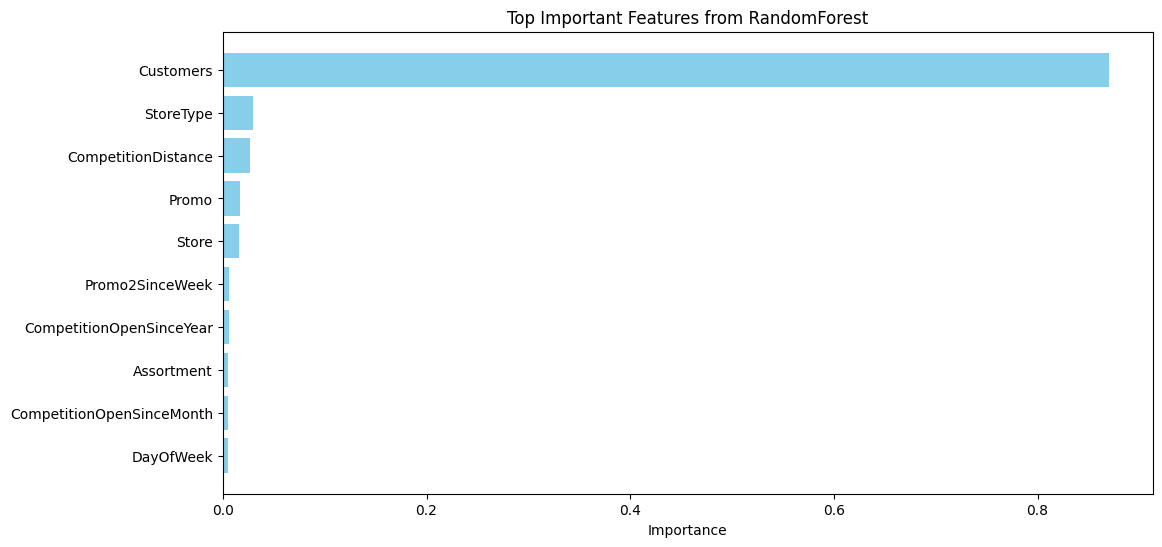

In [35]:
# Plotting the top n important features
top_n = 10  # Set the number of top features to display
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n], color='skyblue')
plt.xlabel('Importance')
plt.title('Top Important Features from RandomForest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

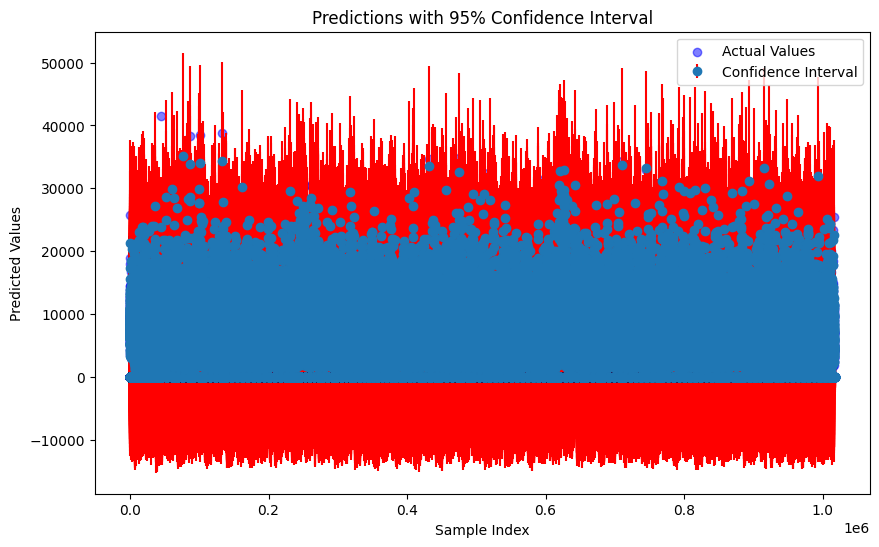

In [38]:
# Confidence Interval estimation (based on the standard deviation of predictions)
y_pred_std = np.std([tree.predict(X_test) for tree in rf_model.estimators_], axis=0)
confidence_interval = 1.96 * y_pred_std  # 95% confidence interval

# Plotting the predictions with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(y_test.index, y_pred_test, yerr=confidence_interval, fmt='o', ecolor='r', capthick=2, label="Confidence Interval")
plt.scatter(y_test.index, y_test, color='blue', label='Actual Values', alpha=0.5)
plt.title("Predictions with 95% Confidence Interval")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

In [39]:
import os
import joblib
from datetime import datetime

# Define the models directory within the Kaggle environment
models_dir = '../notebook/models'  # Use relative path for Kaggle

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

# Serialize model with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"{models_dir}/sales_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)

print(f"Model saved as {model_filename}")


Model saved as ./models/sales_model_2024-09-24-08-13-48.pkl


In [ ]:
import os
import sys
import joblib
from datetime import datetime

# Correct the path
sys.path.append(os.path.abspath('../notebook/models'))

# Ensure the directory exists
os.makedirs('../notebook/models', exist_ok=True)

# Serialize model with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"../notebook/models/sales_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)

print(f"Model saved as {model_filename}")


In [40]:
# 2.6 Building model with deep learning (LSTM)
# Prepare time series data
time_steps = 60

def create_lagged_data(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

sales = df['Sales'].values
scaled_sales = (sales - sales.mean()) / sales.std()  # Scale to (-1, 1)

# Create supervised learning data for LSTM
X_lstm, y_lstm = create_lagged_data(scaled_sales, time_steps)

# Split into train/test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Reshape input for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))

# Predict with LSTM
y_pred_lstm = model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
# print(f"LSTM Model - Test Set MSE: {mse_lstm}")

Epoch 1/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 115s 8ms/step - loss: 0.4159 - val_loss: 0.3257
Epoch 2/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - loss: 0.2934 - val_loss: 0.2236
Epoch 3/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - loss: 0.2108 - val_loss: 0.1854
Epoch 4/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - loss: 0.1683 - val_loss: 0.1559
Epoch 5/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - loss: 0.1470 - val_loss: 0.1395
Epoch 6/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - loss: 0.1347 - val_loss: 0.1326
Epoch 7/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 112s 8ms/step - loss: 0.1274 - val_loss: 0.1243
Epoch 8/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - loss: 0.1215 - val_loss: 0.1205
Epoch 9/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 112s 8ms/step - loss: 0.1154 - val_loss: 0.1177
Epoch 10/10
13228/13228 ━━━━━━━━━━━━━━━━━━━━ 111s 8ms/step - loss: 0.1126 - val_loss: 0.1169
6614/6614 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


In [41]:
# Calculate predictions
y_pred_lstm = model.predict(X_test_lstm)

# Rescale predictions back to original values
y_pred_lstm_rescaled = y_pred_lstm * sales.std() + sales.mean()
y_test_lstm_rescaled = y_test_lstm * sales.std() + sales.mean()

# Calculate metrics
mae_lstm = mean_absolute_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)
mse_lstm = mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)
r2_lstm = r2_score(y_test_lstm_rescaled, y_pred_lstm_rescaled)

print(f"LSTM Model - Test Set MAE: {mae_lstm:.2f}")
print(f"LSTM Model - Test Set MSE: {mse_lstm:.2f}")
print(f"LSTM Model - Test Set R²: {r2_lstm:.2f}")

6614/6614 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
LSTM Model - Test Set MAE: 774.95
LSTM Model - Test Set MSE: 1811518.95
LSTM Model - Test Set R²: 0.88


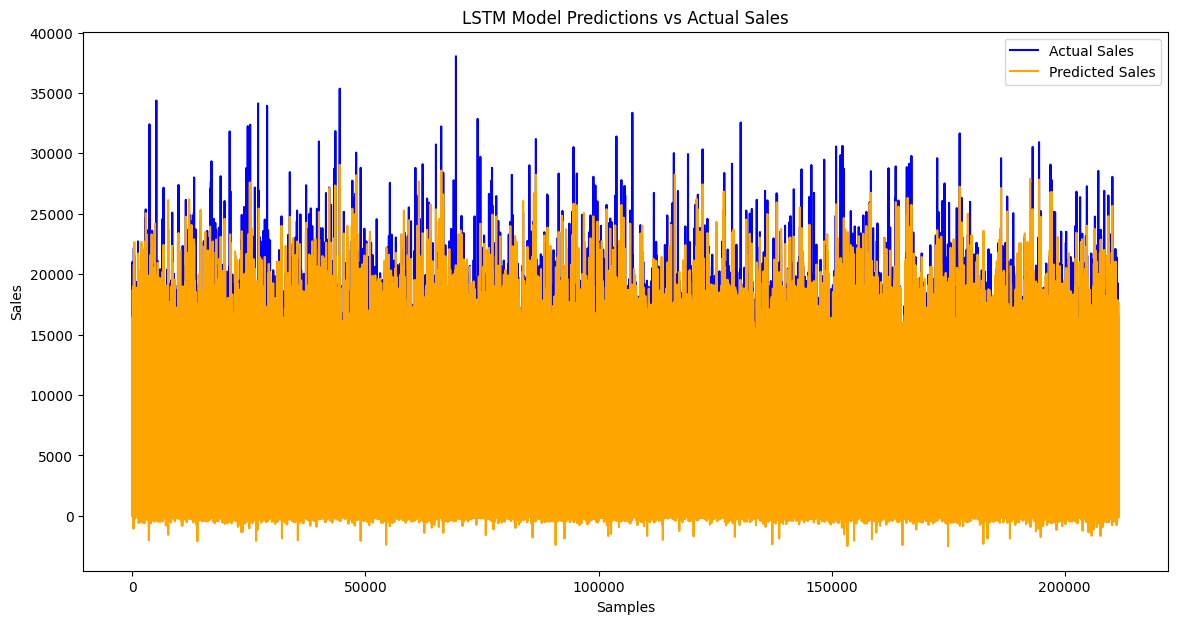

In [42]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm_rescaled, label='Actual Sales', color='blue')
plt.plot(y_pred_lstm_rescaled, label='Predicted Sales', color='orange')
plt.title('LSTM Model Predictions vs Actual Sales')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [43]:
import joblib
from datetime import datetime

# Define a filename with a timestamp
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
lstm_model_filename = f"../notebook/models/lstm_model_{timestamp}.h5"

# Save the model
model.save(lstm_model_filename)
print(f'LSTM model serialized to {lstm_model_filename}')


LSTM model serialized to ../notebook/models/lstm_model_2024-09-24-08-33-46.h5


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Scaling the sales data
sales = df['Sales'].values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales = scaler.fit_transform(sales.reshape(-1, 1))

# Create lagged data for LSTM
def create_lagged_data(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 60
X_lstm, y_lstm = create_lagged_data(scaled_sales, time_steps)

# Split data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Reshape input to be 3D [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build enhanced LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),  # Add dropout for regularization
    LSTM(100, return_sequences=True),  # Additional LSTM layer
    Dropout(0.2),  # Another dropout
    LSTM(50, return_sequences=False),  # Final LSTM layer
    Dense(50, activation='relu'),  # Dense layer to learn more complex representations
    Dense(1)  # Output layer for regression
])

# Compile the model with mean squared error loss
model.compile(optimizer='adam', loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), 
                    callbacks=[early_stop], verbose=2)



Epoch 1/50
13228/13228 - 187s - 14ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 2/50
13228/13228 - 183s - 14ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 3/50
13228/13228 - 184s - 14ms/step - loss: 0.0088 - val_loss: 0.0065
Epoch 4/50
13228/13228 - 184s - 14ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 5/50
13228/13228 - 184s - 14ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 6/50
13228/13228 - 184s - 14ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 7/50
13228/13228 - 184s - 14ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/50
13228/13228 - 184s - 14ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 9/50
13228/13228 - 184s - 14ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 10/50
13228/13228 - 184s - 14ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 11/50
13228/13228 - 184s - 14ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 12/50
13228/13228 - 184s - 14ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 13/50
13228/13228 - 184s - 14ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 14

6614/6614 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
LSTM Model - Test Set MAE: 578.95
LSTM Model - Test Set MSE: 1184775.15
LSTM Model - Test Set R²: 0.92


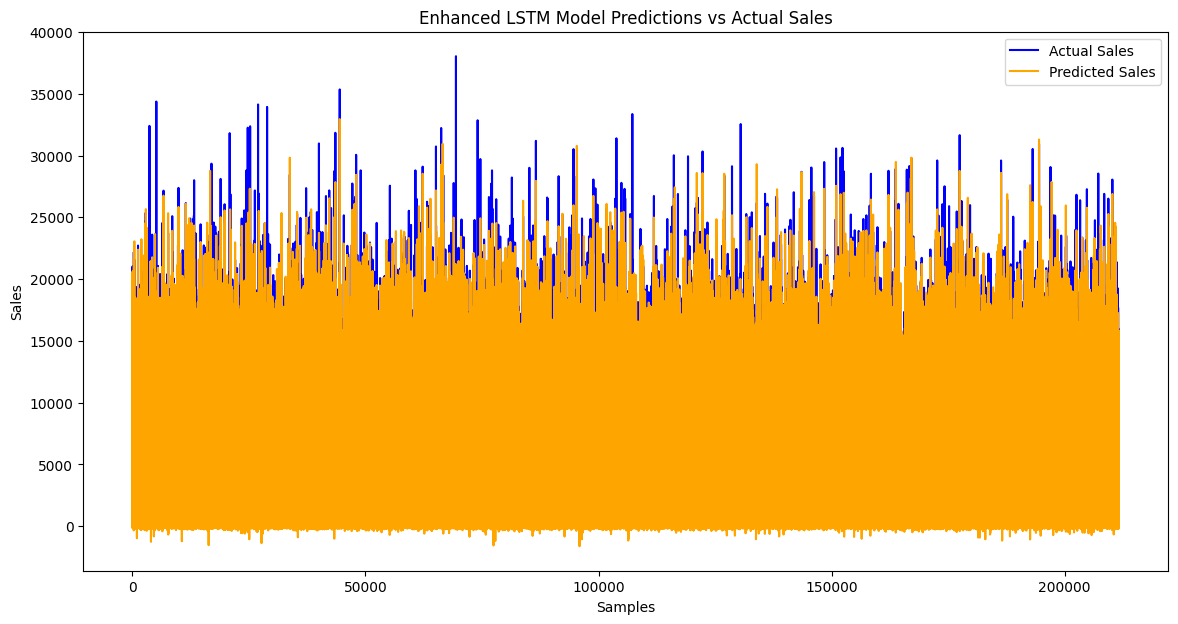

In [45]:
# Predict on test data
y_pred_lstm = model.predict(X_test_lstm)

# Rescale predictions back to original scale
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm)

# Evaluate model
mae_lstm = mean_absolute_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)
mse_lstm = mean_squared_error(y_test_lstm_rescaled, y_pred_lstm_rescaled)
r2_lstm = r2_score(y_test_lstm_rescaled, y_pred_lstm_rescaled)

print(f"LSTM Model - Test Set MAE: {mae_lstm:.2f}")
print(f"LSTM Model - Test Set MSE: {mse_lstm:.2f}")
print(f"LSTM Model - Test Set R²: {r2_lstm:.2f}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_lstm_rescaled, label='Actual Sales', color='blue')
plt.plot(y_pred_lstm_rescaled, label='Predicted Sales', color='orange')
plt.title('Enhanced LSTM Model Predictions vs Actual Sales')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [46]:
# Define the models directory within the Kaggle environment
models_dir = './models'  # Use relative path for Kaggle

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

# Serialize model with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"{models_dir}/sales_model_{timestamp}.pkl"
joblib.dump(pipeline, model_filename)

print(f"Model saved as {model_filename}")


Model saved as ./models/sales_model_2024-09-24-11-14-41.pkl
